In [1]:
import os
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from tqdm.notebook import tqdm

#Libraries to save images to animations
from PIL import Image as Img, ImageSequence
from IPython.display import Image, display


import helper #Custom library to help with data loading and saving samples

transform = transforms.ToTensor()

In [2]:
device = helper.get_default_device()
print(device)

mps


## Step 1 : Configuring default values for network training

In [3]:
#trianing_defaults
batch_size = 128
latent_size = 128

real_targets = torch.ones(batch_size,1)
fake_targets = torch.zeros(batch_size, 1,device=device)

#saved directories
sample_dir = 'generated_5'
model_dir = 'saved_models_5'
animation_name = 'animation.gif'

#Fixed Latent
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)


#Training defaults
lr_d = 0.001
lr_g = 0.0005
epochs = 25


In [4]:
#Label smoothing
real_targets = real_targets - 0.2 + (torch.randn(real_targets.shape) * 0.05)
real_targets = real_targets.to(device)
# print(torch.mean(real_targets),torch.max(real_targets), torch.min(real_targets))


Applying label smoothing to the real target values (1) helps to prevent extreme extrapolation behavior in the discriminator.

## Step 2 : Dataset Handling

In [5]:
if 'cifar-10-batches-py' in os.listdir('data/'):
    train_ =True
else:
    train_ = False

In [6]:
dataset = datasets.CIFAR10(root = './data',train=train_,download=False, transform = transform)
dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True)

#Moving data to GPU/MPS
train_dl = helper.DeviceDataLoader(dataloader,device)

## Step 3 :  Defining Generator/Discriminator Architecture

In [7]:
generator = nn.Sequential(
 
    #in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #out: 512 x 4 x 4
    
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 32, kernel_size=1, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 32 x 32 x 32

    nn.ConvTranspose2d(32, 3, kernel_size=1, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(3),
    nn.Tanh()
#     out: 3 x 32 x 32
)

The generator architecture is based on the default DCGAN architecture. It starts with an input of dimension 'latent_size x 1 x 1', which is then converted to 512 x 4 x 4 via nn.ConvTranspose2d. Eventually 4 other ConvTranspose2d convolutions are used to convert it into a 3x32x32 sample.

Similarly, the discriminator converts a 3x32x32 sample into a single scalar value specifying whether the image is fake or real.

As suggested in DCGAN paper, we are using BatchNormalization after each layers and a Tanh function at generator outputs. Similarly, for the discriminator, fully connected layer has been replaced by flattening and a sigmoid layer. This is supposed to be increasing stability, improve speed and avoid mode collapses

In [8]:
discriminator = nn.Sequential(
    # in: 3 x 32 x 32

    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),

    #second convolutional layer : input = 64*16*16, output = 128*8*8,
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    #third convolutional layer : input = 128*8*8, output = 256*4*4,
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    #fourth convolutional layer : input = 256*4*4, output = 512*8*8,
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(512, 1, kernel_size=2, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid())

In [9]:
# Moving both the models to GPU
discriminator = discriminator.to(device)
generator = generator.to(device)

In [10]:
def train_discriminator(real_images, opt_d):
    ''' Function to train discriminator'''
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
#     real_score = torch.mean(real_preds).item()
    
    # Generate fake images using the latest generator
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
#     fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    return loss.item()

In [11]:
def train_generator(opt_g):
    ''' Function to train discriminator'''
    
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Pass the samples through the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [12]:
# helper.save_samples(0,fixed_latent,generator,sample_dir)


In [13]:
def get_norm(model):
    '''The get_norm function keeps track of exploding/vanishing gradients 
    to help us determine when and if the model is being unstable''' 

    total_norm=0
    for p in model.parameters():
        param_norm = p.grad.data.norm(2)
        total_norm += param_norm.item() ** 2

    total_norm = total_norm ** (1. / 2)
    return total_norm



def fit(epochs, lr_g,lr_d, start_idx=1):
    ''' Main function that starts the training loop for discriminator and generator '''

    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
#         real_scores.append(real_score)
#         fake_scores.append(fake_score)
        
        
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], Generator Loss: {:.4f}, Discriminator Loss: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d))
        print(f'Generator Norms : {get_norm(generator)}, Discriminator Norms : {get_norm(discriminator)} ')
        
        
        # Save generated images
        generator_scripted = torch.jit.script(generator.to('cpu'))
        generator_scripted.save(f'{model_dir}/generator_{start_idx+epoch}.pt')
        generator.to(device)
        
        helper.save_samples(epoch+start_idx, fixed_latent,generator,sample_dir)
    
    return losses_g, losses_d

def save_history(history):
    ''' Function to save losses'''
    
    with open(f'{model_dir}/history_data.csv','a') as csvfile:
        np.savetxt(csvfile, history,delimiter=',')
        
    csvfile.close()

## Training approach:
As the models were not stabilizing, with losses oscillating , I chose to train different epochs with different learning rates, with learning rate eventually decaying by ratio of 4,8,15 and 20.

In [15]:
history = fit(10, lr_d,lr_g)
save_history(history)

In [19]:
history2 = fit(epochs, lr_d/4,lr_g/4,start_idx=26)
save_history(history2)

  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [1/25], Generator Loss: 4.3875, Discriminator Loss: 0.6116
Generator Norms : 85.02541578469378, Discriminator Norms : 131.85608290255743 
Saving generated-images-0026.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [2/25], Generator Loss: 4.5861, Discriminator Loss: 0.7771
Generator Norms : 140.3354616526763, Discriminator Norms : 184.38387590012297 
Saving generated-images-0027.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [3/25], Generator Loss: 3.1698, Discriminator Loss: 0.6810
Generator Norms : 39.93123663917187, Discriminator Norms : 79.7555986690805 
Saving generated-images-0028.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [4/25], Generator Loss: 0.3635, Discriminator Loss: 2.5925
Generator Norms : 18.659732030112643, Discriminator Norms : 322.67323909635024 
Saving generated-images-0029.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [5/25], Generator Loss: 2.9186, Discriminator Loss: 0.6495
Generator Norms : 67.70791063665826, Discriminator Norms : 103.56779243486459 
Saving generated-images-0030.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [6/25], Generator Loss: 2.3473, Discriminator Loss: 0.6656
Generator Norms : 83.21934656682983, Discriminator Norms : 125.80093994743673 
Saving generated-images-0031.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [7/25], Generator Loss: 2.1698, Discriminator Loss: 0.6069
Generator Norms : 87.64824117947157, Discriminator Norms : 123.98178564559356 
Saving generated-images-0032.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [8/25], Generator Loss: 6.7487, Discriminator Loss: 1.0528
Generator Norms : 114.26067001720352, Discriminator Norms : 236.49394746140322 
Saving generated-images-0033.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [9/25], Generator Loss: 3.4701, Discriminator Loss: 0.5897
Generator Norms : 105.73711759895225, Discriminator Norms : 163.3919704746752 
Saving generated-images-0034.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [10/25], Generator Loss: 3.5847, Discriminator Loss: 0.7256
Generator Norms : 150.2356770543096, Discriminator Norms : 170.35904808548236 
Saving generated-images-0035.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [11/25], Generator Loss: 3.0376, Discriminator Loss: 0.6903
Generator Norms : 186.0468384976734, Discriminator Norms : 250.7254806965897 
Saving generated-images-0036.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [12/25], Generator Loss: 1.7664, Discriminator Loss: 0.7091
Generator Norms : 115.26534339120774, Discriminator Norms : 146.9127689831699 
Saving generated-images-0037.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [13/25], Generator Loss: 2.6121, Discriminator Loss: 0.6382
Generator Norms : 86.79846533801592, Discriminator Norms : 172.6016245355766 
Saving generated-images-0038.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [14/25], Generator Loss: 2.0661, Discriminator Loss: 0.5852
Generator Norms : 130.89045268708952, Discriminator Norms : 131.1777975169389 
Saving generated-images-0039.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [15/25], Generator Loss: 2.2294, Discriminator Loss: 0.8996
Generator Norms : 139.06545129423253, Discriminator Norms : 276.6788487006275 
Saving generated-images-0040.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [16/25], Generator Loss: 3.4404, Discriminator Loss: 0.6959
Generator Norms : 248.09123232946888, Discriminator Norms : 327.4376461035774 
Saving generated-images-0041.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [17/25], Generator Loss: 2.5883, Discriminator Loss: 0.6174
Generator Norms : 97.71245785210162, Discriminator Norms : 158.21178800332547 
Saving generated-images-0042.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [18/25], Generator Loss: 3.4166, Discriminator Loss: 0.5989
Generator Norms : 173.24613505657595, Discriminator Norms : 218.86069630932147 
Saving generated-images-0043.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [19/25], Generator Loss: 5.6435, Discriminator Loss: 1.3095
Generator Norms : 181.624797725897, Discriminator Norms : 349.143249501165 
Saving generated-images-0044.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [20/25], Generator Loss: 3.3147, Discriminator Loss: 0.7231
Generator Norms : 174.7757778959139, Discriminator Norms : 280.65987570581245 
Saving generated-images-0045.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [21/25], Generator Loss: 2.7410, Discriminator Loss: 0.8787
Generator Norms : 193.86352568671347, Discriminator Norms : 310.713937620768 
Saving generated-images-0046.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [22/25], Generator Loss: 3.6032, Discriminator Loss: 0.6367
Generator Norms : 260.4627692852844, Discriminator Norms : 420.171708405601 
Saving generated-images-0047.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [23/25], Generator Loss: 2.0868, Discriminator Loss: 0.5868
Generator Norms : 164.60033378058148, Discriminator Norms : 307.39370006073716 
Saving generated-images-0048.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [24/25], Generator Loss: 4.0719, Discriminator Loss: 0.7274
Generator Norms : 256.5381593419752, Discriminator Norms : 371.6540237567224 
Saving generated-images-0049.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [25/25], Generator Loss: 3.0081, Discriminator Loss: 0.7392
Generator Norms : 192.75865668404396, Discriminator Norms : 392.3944449405134 
Saving generated-images-0050.png


In [20]:
history3 = fit(epochs, lr_d/8,lr_g/8,start_idx=51)
save_history(history3)

  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [1/25], Generator Loss: 3.4096, Discriminator Loss: 0.6377
Generator Norms : 68.70809976768112, Discriminator Norms : 115.24125701118851 
Saving generated-images-0051.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [2/25], Generator Loss: 3.5632, Discriminator Loss: 0.5716
Generator Norms : 137.2090685275656, Discriminator Norms : 197.58895639246143 
Saving generated-images-0052.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [3/25], Generator Loss: 3.2193, Discriminator Loss: 0.5829
Generator Norms : 157.89228998482227, Discriminator Norms : 227.23630043614895 
Saving generated-images-0053.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [4/25], Generator Loss: 4.1006, Discriminator Loss: 0.5679
Generator Norms : 124.25948848187944, Discriminator Norms : 222.6435656472736 
Saving generated-images-0054.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [5/25], Generator Loss: 3.6206, Discriminator Loss: 0.6045
Generator Norms : 188.81998807547055, Discriminator Norms : 286.6677652756032 
Saving generated-images-0055.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [6/25], Generator Loss: 4.2937, Discriminator Loss: 0.6329
Generator Norms : 248.07163372282, Discriminator Norms : 324.7171719729833 
Saving generated-images-0056.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [7/25], Generator Loss: 3.2074, Discriminator Loss: 0.5625
Generator Norms : 167.0169360319931, Discriminator Norms : 205.01107832832076 
Saving generated-images-0057.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [8/25], Generator Loss: 3.4056, Discriminator Loss: 0.6353
Generator Norms : 172.53349803356878, Discriminator Norms : 238.19947092204833 
Saving generated-images-0058.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [9/25], Generator Loss: 3.9007, Discriminator Loss: 0.7287
Generator Norms : 199.06825734902444, Discriminator Norms : 259.1717583683815 
Saving generated-images-0059.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [10/25], Generator Loss: 2.7551, Discriminator Loss: 0.5690
Generator Norms : 94.2750000437283, Discriminator Norms : 160.45744063924812 
Saving generated-images-0060.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [11/25], Generator Loss: 2.4379, Discriminator Loss: 0.5610
Generator Norms : 264.9824992900408, Discriminator Norms : 439.8128277433362 
Saving generated-images-0061.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [12/25], Generator Loss: 3.4727, Discriminator Loss: 0.5780
Generator Norms : 246.81776765083882, Discriminator Norms : 326.271508198155 
Saving generated-images-0062.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [13/25], Generator Loss: 3.8988, Discriminator Loss: 0.5735
Generator Norms : 188.8351528397462, Discriminator Norms : 291.56441687349513 
Saving generated-images-0063.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [14/25], Generator Loss: 2.6116, Discriminator Loss: 0.5646
Generator Norms : 157.80591918308184, Discriminator Norms : 219.88514173494937 
Saving generated-images-0064.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [15/25], Generator Loss: 2.2624, Discriminator Loss: 0.6259
Generator Norms : 110.48801545727109, Discriminator Norms : 182.8674113175667 
Saving generated-images-0065.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [16/25], Generator Loss: 2.5387, Discriminator Loss: 0.6219
Generator Norms : 133.05883292879244, Discriminator Norms : 190.69510993561858 
Saving generated-images-0066.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [17/25], Generator Loss: 3.4376, Discriminator Loss: 0.6107
Generator Norms : 264.19447490087146, Discriminator Norms : 356.5940464066452 
Saving generated-images-0067.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [18/25], Generator Loss: 3.5771, Discriminator Loss: 0.6097
Generator Norms : 227.91470155103255, Discriminator Norms : 342.83894958743286 
Saving generated-images-0068.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [19/25], Generator Loss: 3.6805, Discriminator Loss: 0.5516
Generator Norms : 356.25249735084543, Discriminator Norms : 577.1237407834208 
Saving generated-images-0069.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [20/25], Generator Loss: 2.3347, Discriminator Loss: 0.6143
Generator Norms : 120.50156075239094, Discriminator Norms : 176.68124657233577 
Saving generated-images-0070.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [21/25], Generator Loss: 2.2323, Discriminator Loss: 0.5717
Generator Norms : 122.0547595940046, Discriminator Norms : 211.9718644700452 
Saving generated-images-0071.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [22/25], Generator Loss: 3.0895, Discriminator Loss: 0.5747
Generator Norms : 234.01788433422976, Discriminator Norms : 422.7198480572824 
Saving generated-images-0072.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [23/25], Generator Loss: 2.8669, Discriminator Loss: 0.5670
Generator Norms : 156.58155478122285, Discriminator Norms : 242.2534571252902 
Saving generated-images-0073.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [24/25], Generator Loss: 2.3163, Discriminator Loss: 0.6081
Generator Norms : 314.30598264341864, Discriminator Norms : 509.11361329700514 
Saving generated-images-0074.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [25/25], Generator Loss: 4.2800, Discriminator Loss: 0.5848
Generator Norms : 242.67307696442018, Discriminator Norms : 366.1410988966351 
Saving generated-images-0075.png


In [21]:
history4 = fit(epochs, lr_d/15,lr_g/15,start_idx=76)
save_history(history4)

  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [1/25], Generator Loss: 2.8231, Discriminator Loss: 0.5474
Generator Norms : 71.09688462901111, Discriminator Norms : 139.264069362667 
Saving generated-images-0076.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [2/25], Generator Loss: 3.3538, Discriminator Loss: 0.6215
Generator Norms : 114.28085071686013, Discriminator Norms : 272.656780694909 
Saving generated-images-0077.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [3/25], Generator Loss: 3.8461, Discriminator Loss: 0.5240
Generator Norms : 169.48324151260923, Discriminator Norms : 325.12942716655647 
Saving generated-images-0078.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [4/25], Generator Loss: 3.1280, Discriminator Loss: 0.5228
Generator Norms : 94.01124874028197, Discriminator Norms : 177.74481769022603 
Saving generated-images-0079.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [5/25], Generator Loss: 4.0838, Discriminator Loss: 0.5421
Generator Norms : 68.39891487390418, Discriminator Norms : 155.3660512404359 
Saving generated-images-0080.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [6/25], Generator Loss: 2.8963, Discriminator Loss: 0.5511
Generator Norms : 76.95110420263075, Discriminator Norms : 128.1014066531546 
Saving generated-images-0081.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [7/25], Generator Loss: 3.8186, Discriminator Loss: 0.5386
Generator Norms : 128.6131815002566, Discriminator Norms : 215.84380908379492 
Saving generated-images-0082.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [8/25], Generator Loss: 4.2625, Discriminator Loss: 0.5664
Generator Norms : 363.7879957590397, Discriminator Norms : 610.4649503488467 
Saving generated-images-0083.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [9/25], Generator Loss: 3.8116, Discriminator Loss: 0.5794
Generator Norms : 109.77982393995704, Discriminator Norms : 167.65643573817357 
Saving generated-images-0084.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [10/25], Generator Loss: 3.8982, Discriminator Loss: 0.5474
Generator Norms : 245.84601542641147, Discriminator Norms : 225.6756559948805 
Saving generated-images-0085.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [11/25], Generator Loss: 3.0010, Discriminator Loss: 0.5557
Generator Norms : 103.58492152698122, Discriminator Norms : 209.77189108439114 
Saving generated-images-0086.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [12/25], Generator Loss: 3.4820, Discriminator Loss: 0.5980
Generator Norms : 268.43902859646613, Discriminator Norms : 427.4195775440935 
Saving generated-images-0087.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [13/25], Generator Loss: 3.7710, Discriminator Loss: 0.6177
Generator Norms : 118.02396802012642, Discriminator Norms : 227.1509079741257 
Saving generated-images-0088.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [14/25], Generator Loss: 3.5207, Discriminator Loss: 0.5511
Generator Norms : 206.40773666170577, Discriminator Norms : 278.97000544870616 
Saving generated-images-0089.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [15/25], Generator Loss: 2.4989, Discriminator Loss: 0.6081
Generator Norms : 188.9279144570305, Discriminator Norms : 290.7498925080522 
Saving generated-images-0090.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [16/25], Generator Loss: 3.9000, Discriminator Loss: 0.5566
Generator Norms : 161.65508539929738, Discriminator Norms : 383.29035034208147 
Saving generated-images-0091.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [17/25], Generator Loss: 4.3183, Discriminator Loss: 0.6347
Generator Norms : 117.40536887149358, Discriminator Norms : 302.55860288825625 
Saving generated-images-0092.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [18/25], Generator Loss: 5.3628, Discriminator Loss: 0.5250
Generator Norms : 145.50835654207347, Discriminator Norms : 285.13640733728096 
Saving generated-images-0093.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [19/25], Generator Loss: 3.8099, Discriminator Loss: 0.5331
Generator Norms : 86.8886641324567, Discriminator Norms : 266.25158344953326 
Saving generated-images-0094.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [20/25], Generator Loss: 3.9402, Discriminator Loss: 0.5420
Generator Norms : 120.31872627281032, Discriminator Norms : 240.03327770119913 
Saving generated-images-0095.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [21/25], Generator Loss: 4.4365, Discriminator Loss: 0.5469
Generator Norms : 140.41008129903724, Discriminator Norms : 228.65953893302176 
Saving generated-images-0096.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [22/25], Generator Loss: 3.4851, Discriminator Loss: 0.5154
Generator Norms : 431.3316174799884, Discriminator Norms : 670.5334355912505 
Saving generated-images-0097.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [23/25], Generator Loss: 4.0637, Discriminator Loss: 0.5341
Generator Norms : 69.60017884432067, Discriminator Norms : 212.5424129807952 
Saving generated-images-0098.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [24/25], Generator Loss: 3.6079, Discriminator Loss: 0.5374
Generator Norms : 64.35510165620224, Discriminator Norms : 169.1196218415362 
Saving generated-images-0099.png


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [25/25], Generator Loss: 3.6952, Discriminator Loss: 0.5153
Generator Norms : 113.45151803611176, Discriminator Norms : 227.33492269570098 
Saving generated-images-0100.png


## Step 4 : Plotting the generator and discriminator loss

In the fit function, we save the model loss and generator object in the /saved_models_{{index}} directory. Now we load the saved losses in order to generate a loss plot.

In [36]:
with open(f'saved_models_5/history_data.csv') as f:
    history = f.readlines()
    
clean = []
for element in history:
    element = element.strip('\n').split(',')
    temp = [float(x) for x in element]
    clean.append(temp)

gen_index = list(range(0,len(clean),2))
disc_index = list(range(1,len(clean),2))
gen_history = [clean[x] for x in gen_index]
gen_history = [item for sublist in gen_history for item in sublist]
disc_history = [clean[x] for x in disc_index]
disc_history = [item for sublist in disc_history for item in sublist]


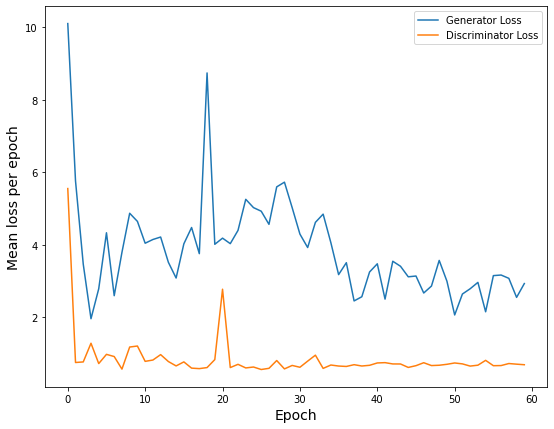

In [37]:
plt.figure(figsize=(9,7))
plt.plot(gen_history, label = 'Generator Loss')
plt.plot(disc_history, label = 'Discriminator Loss')
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Mean loss per epoch',fontsize = 14)
plt.legend()
plt.show()



## Step 5 : Animation to show different images generated during different epochs

In [38]:
# Set the file names for your images
file_names = os.listdir(f'{sample_dir}/')
file_names = sorted([f'{sample_dir}/'+x for x in file_names])

# Open each image and append it to the list of frames
frames = []
for file_name in file_names:
    with Img.open(file_name) as image:
        frames.append(image.copy())

# Save the frames as an animated GIF
frames[0].save(f'{animation_name}', format='GIF', append_images=frames[1:], save_all=True, duration=200, loop=0)


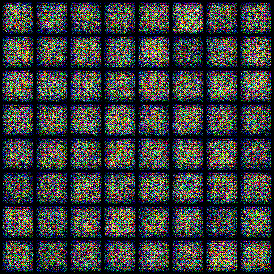

In [39]:
# Display the animated GIF
with open('animation.gif','rb') as f:
    display(Image(data=f.read(), format='png',width=420),clear=True)

### Animation plot for generated images in 80 epochs

## Step 6 : Displaying a new image from any random latent vector

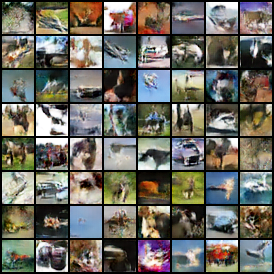

Generator used : saved_models_5/generator_88.pt


In [41]:
new_latent = torch.randn(64, latent_size, 1, 1, device=device)

#Loading a random generator from any of the epochs
x = [x for x in os.listdir(f'{model_dir}') if 'generator_' in x and 'pt' in x]
valid_epochs = [int(k.split('_')[1].strip('.pt')) for k in x if int(k.split('_')[1].strip('.pt')) > 30]
generator_rand = np.random.choice(valid_epochs)
final_generator = torch.jit.load(f'{model_dir}/generator_{generator_rand}.pt')

final_generator.to(device)
generated_images = final_generator(fixed_latent)

helper.save_samples(1011,new_latent,final_generator,f'{sample_dir}/')
# Display the generated_image
with open(f'{sample_dir}/generated-images-1011.png','rb') as f:
    display(Image(data=f.read(), format='png',width=400),clear=True,metadata = generator_rand)
    print(f'Generator used : {model_dir}/generator_{generator_rand}.pt')